In [1]:
#%matplotlib qt
%matplotlib inline
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
# RS: doubled checked 5/22/19
# magnification between first plane and considered plane, 
#dgammaErrFactor in HiCAT_APLCSP_spreadsheet in hicat_aplc repo
delta_gamma = 0.004

gamma_21 = 0.423
delta_gamma_21 = gamma_21 * delta_gamma

gamma_31 = 1.008
delta_gamma_31 =gamma_31 * delta_gamma

gamma_41 = 0.444
delta_gamma_41 = gamma_41 * delta_gamma

gamma_51 = 0.979
delta_gamma_51 = gamma_51 * delta_gamma
print(delta_gamma_21,delta_gamma_31,delta_gamma_41,delta_gamma_51)

0.001692 0.004032 0.001776 0.003916


# P2 - Segmented primary mirror 

In [3]:
# RS: doubled checked 5/22/19

In [4]:
p2_irisao_segment_size = 1.4e-3 # m (note: point to point)
p2_irisao_segment_side_length = p2_irisao_segment_size / 2
p2_irisao_segment_gap_size = 12e-6 # m
#p2_irisao_segment_gap_size = 1.212e-3/10 # note: creating a DM where gaps = 1/10 segments, tested and working using DS9
p2_irisao_inscribed_circle_size = 10 * p2_irisao_segment_side_length
p2_irisao_flat_to_flat_size = 14 * np.sqrt(3) / 2 * p2_irisao_segment_side_length
p2_irisao_circumscribed_circle_size = np.sqrt(p2_irisao_flat_to_flat_size**2 + p2_irisao_segment_side_length**2)


# Spiders
p2_pupil_mask_spider_thickness = p2_irisao_segment_gap_size # m

print(p2_irisao_inscribed_circle_size)
print(p2_irisao_circumscribed_circle_size)
print(p2_irisao_flat_to_flat_size)

0.007
0.008515867542417507
0.008487048957087498


In [5]:
irisao_gap_hexagon_fraction = p2_irisao_segment_gap_size / p2_irisao_segment_side_length
print(irisao_gap_hexagon_fraction, 0.012 / 0.7)

0.017142857142857144 0.017142857142857144


In [6]:
p2_irisao_distance_between_segments = p2_irisao_segment_side_length * np.sqrt(3)
#corrected bug, sqrt(3) replaced by 2/sqrt(3)
# tested with this value for gap size==1/10 segment size; p2_irisao_segment_gap_size = 1.212e-3/10 (measurable in DS9)
p2_irisao_segment_circumdiameter = (2 * p2_irisao_segment_side_length) - (2/np.sqrt(3)) * p2_irisao_segment_gap_size
print(p2_irisao_segment_circumdiameter)

def p2_irisao():
    segment = hexagonal_aperture(p2_irisao_segment_circumdiameter, np.pi/2)
    
    segment_positions = make_hexagonal_grid(p2_irisao_distance_between_segments, 3, False)
    central_segment = hexagonal_aperture(p2_irisao_segment_size, np.pi / 2)

    spider1 = make_spider_infinite([0,0], 60, p2_pupil_mask_spider_thickness)
    spider2 = make_spider_infinite([0,0], 120, p2_pupil_mask_spider_thickness)
    spider3 = make_spider_infinite([0,0], -60, p2_pupil_mask_spider_thickness)
    spider4 = make_spider_infinite([0,0], -120, p2_pupil_mask_spider_thickness)
    
    aperture = make_segmented_aperture(segment, segment_positions)
    aperture_index = make_segmented_aperture(segment, segment_positions, segment_transmissions=np.arange(0,37))
    
    def aper(grid):
        return (aperture(grid) - central_segment(grid)) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    
    def aper_index(grid):
        return (aperture_index(grid)) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    
    return aper, aper_index, segment_positions


0.001386143593539449


# P5 - Lyot stop

In [7]:
lyot_stop_size = 0.98*p2_irisao_inscribed_circle_size
lyot_stop_central_obstruction = 1.37*p2_irisao_segment_size

In [8]:
def p5_lyot_stop():
    outer_diameter = circular_aperture(lyot_stop_size)
    central_obscuration = circular_aperture(lyot_stop_central_obstruction)
    
    def aper(grid):
        return (outer_diameter(grid) - central_obscuration(grid))
    return aper

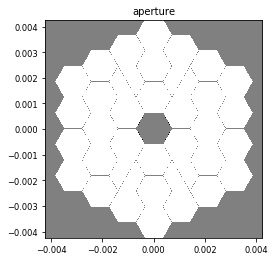

In [9]:
# Here the reference is plane P2 - but the largest size of the array is for the Boston DM (largest optic)
nPixelAperture = 1000 
g = make_pupil_grid(nPixelAperture,p2_irisao_flat_to_flat_size)
supersampling = 1

telescopePupil = evaluate_supersampled(p2_irisao()[0], g, supersampling)
telescopePupil_indexed = evaluate_supersampled(p2_irisao()[1], g, supersampling)
segment_positions = p2_irisao()[2]


lyot_stop = evaluate_supersampled(p5_lyot_stop(), g, supersampling)

hdr_indexed = fits.Header()
seg_xys = segment_positions.points
for segment in range(seg_xys.shape[0]):
    hdr_indexed.set('seg'+str(segment+1)+'_x',segment_positions.x[segment],'x-position segment '+str(segment+1))
    hdr_indexed.set('seg' + str(segment + 1) + '_y', segment_positions.y[segment],'y-position segment ' + str(segment + 1))



write_fits(telescopePupil, 'masks/PASTIS/telescopePupil_pastis.fits')
write_fits(lyot_stop, 'masks/PASTIS/lyot_stop_pastis.fits')
fits.writeto('masks/PASTIS/telescopePupil_indexed_pastis.fits', telescopePupil_indexed.shaped, hdr_indexed, overwrite=True)


plt.figure()
plt.title('aperture')
imshow_field(telescopePupil, cmap='gray')
plt.show()